### 2. Modeling
#### ② Multi-class Classification

모델링은 두 가지 방식으로 이루어진다. 정해진 sequence의 길이에 따라 대출했던 도서의 레이블을 배열로 저장하고, 그 길이 이후의 모든 책을 y로 둘지, 마지막 책 하나만을 y로 둘지. 아래의 코드는 특정한 length 이후의 모든 대출 도서를 예측하는 것으로 Multi-label Classification task를 해결하는 코드이다.

In [ ]:
import pandas as pd 
import numpy as np
import datetime
import os

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from keras import metrics

In [ ]:
file_path = '../'

In [ ]:
## load input data

student = pd.read_csv(os.path.join(file_path, 'student_final.csv'))
X_college_train = student['college_index']-1   #college_index include 0: None

X_sequence_train = np.load(os.path.join(file_path, 'input_x_multilabel.npy'))

y_sequence_train = np.load(os.path.join(file_path, 'input_y_multilabel.npy'))


print("X_sequence_train shape : ", X_sequence_train.shape)
print("college shape : ", X_college_train.shape)
print("y shape : ", y_sequence_train.shape)


# X_sequence_train shape :  (502, 10)
# college shape :  (502,)
# y shape :  (502, 374)

In [ ]:
## load embeddings

#image_embedding
image_embeddings = np.load(os.path.join(file_path, 'image_embed.npy'))
min_max_scaler = MinMaxScaler()
image_embeddings = min_max_scaler.fit_transform(image_embeddings)
print("image embedding : ", image_embeddings.shape)

#page-year embedding
page_embeddings = np.load(os.path.join(file_path, 'page_year_embed.npy'))
min_max_scaler = MinMaxScaler()
page_embeddings = min_max_scaler.fit_transform(page_embeddings)
print("page embedding : ", page_embeddings.shape) 


#BERT genre embedding 
genre_embeddings = np.load(os.path.join(file_path, 'genre_embed.npy'))
min_max_scaler = MinMaxScaler()
genre_embeddings = min_max_scaler.fit_transform(genre_embeddings)
print("genre embedding : ", genre_embeddings.shape)


#bert title embedding 
title_embeddings = np.load(os.path.join(file_path, 'title_embed.npy'))
min_max_scaler = MinMaxScaler()
title_embeddings = min_max_scaler.fit_transform(title_embeddings)
print("title embedding : ", title_embeddings.shape)

#bert college embedding 
college_embeddings = np.load(os.path.join(file_path, 'college_embed.npy'))
min_max_scaler = MinMaxScaler()
college_embeddings = min_max_scaler.fit_transform(college_embeddings)
print("college_embedding : ", college_embeddings.shape) 


# image embedding :  (374, 1280)
# page embedding :  (374, 6)
# genre embedding :  (374, 768)
# title embedding :  (374, 768)
# college_embedding :  (13, 768)

In [ ]:
np.random.seed(2021)
tf.random.set_seed(2021)

LEARNING_RATE = 0.01
DROPOUT_PCT = 0.5
ALPHA = 0.1

student_num = X_sequence_train.shape[0]
book_num = title_embeddings.shape[0]
text_embed_dim = 768
img_embed_dim = 1280


#INPUT 
sequence_len = 10
book = tf.keras.Input(shape=(sequence_len, ), name='book-table') # sequences of book label for each student
user = tf.keras.Input(shape=(1, ), name='user-table') #college id of students


#EMBEDDING 
#book title 
title_embedding_layer = tf.keras.layers.Embedding(input_dim = book_num,
                                                  output_dim = text_embed_dim,
                                                  input_length = sequence_len, 
                                                  weights = [title_embeddings],
                                                  name = 'RoBERT-title-embedding',
                                                  # trainable = True,
                                                  # mask_zero = False,
                                                  )


#book cover 
cover_embedding_layer = tf.keras.layers.Embedding(input_dim = book_num,
                                                  output_dim = img_embed_dim, 
                                                  input_length = sequence_len, 
                                                  weights = [image_embeddings],
                                                  name = 'efficientNet-book-cover-embedding'
                                                  # trainable = True, 
                                                  # mask_zero = False,
                                                  )


#genre 
genre_embedding_layer = tf.keras.layers.Embedding(input_dim = book_num, 
                                                  output_dim = text_embed_dim, 
                                                  input_length = sequence_len, 
                                                  weights = [genre_embeddings],
                                                  name = 'RoBERT-book-genre-embedding',
                                                  # trainable = True, 
                                                  # mask_zero = False,
                                                  )


#book_age(pub year) &  page 
metadata_embedding_layer = tf.keras.layers.Embedding(input_dim = book_num,
                                                     output_dim = page_embeddings.shape[1], 
                                                     input_length = sequence_len, 
                                                     weights = [page_embeddings],
                                                     name = 'book-metadata-embedding',
                                                     # trainable = True, 
                                                     # mask_zero = False,
                                                     )

#college 
college_embedding_layer = tf.keras.layers.Embedding(input_dim = college_embeddings.shape[0],  #22024
                                                  output_dim = text_embed_dim,  #768
                                                  input_length = 1, 
                                                  weights = [college_embeddings],
                                                  name = 'RoBERT-user-college-embedding',
                                                  # mask_zero = False,
                                                  # trainable = True
                                                  )



#DENSE LAYER 
dense_1 = tf.keras.layers.Dense(units = 1024, activation = 'relu', name = 'dense_1',kernel_initializer = 'he_uniform')
dense_2 = tf.keras.layers.Dense(units = 2048, activation = 'tanh', name = 'dense_2',kernel_initializer = 'he_uniform')

dense_output = tf.keras.layers.Dense(page_embeddings.shape[0], activation = 'sigmoid', name = 'sigmoid_output')
dropout_1= tf.keras.layers.Dropout(DROPOUT_PCT, name = 'dropout1')


#EMBEDDINGS 
title_embeddings = title_embedding_layer(book)
title = tf.keras.layers.GlobalAveragePooling1D(name = 'AvgPooling_embedding1')(title_embeddings)

cover_embeddings = cover_embedding_layer(book)
image = tf.keras.layers.GlobalAveragePooling1D(name = 'AvgPooling_embedding2')(cover_embeddings)

genre_embeddings = genre_embedding_layer(book)
genre = tf.keras.layers.GlobalAveragePooling1D(name = 'AvgPooling_embedding3')(genre_embeddings)

metadata_embeddings = metadata_embedding_layer(book)
info = tf.keras.layers.GlobalAveragePooling1D(name = 'AvgPooling_embedding4')(metadata_embeddings)

college_embeddings = college_embedding_layer(user)
college = tf.keras.layers.GlobalAveragePooling1D(name = 'AvgPooling_embedding5')(college_embeddings)



#BUILD MODEL 

#CONCAT : title, genre, college
concat_inputs = tf.keras.layers.Concatenate(axis = 1, name = 'concat-inputs')([image, info, title, genre, college])
concat_inputs = tf.keras.layers.BatchNormalization(name = 'concat_batch_norm')(concat_inputs)


#DENSE 
dense_1_features = dense_1(concat_inputs)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_features)
dense_1_relu = dense_1_batch_norm

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = dense_2_features
dense_2_dropout = dropout_1(dense_2_relu)

outputs = dense_output(dense_2_dropout)



#Optimizer
optimizer= tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE, name='rmsprop')


model = tf.keras.models.Model(inputs = [book, user], outputs = [outputs])

model.compile(optimizer = optimizer,
              loss = 'binary_crossentropy',
              metrics = ['categorical_accuracy']) 

# VISUALIZATION 
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,dpi=96)

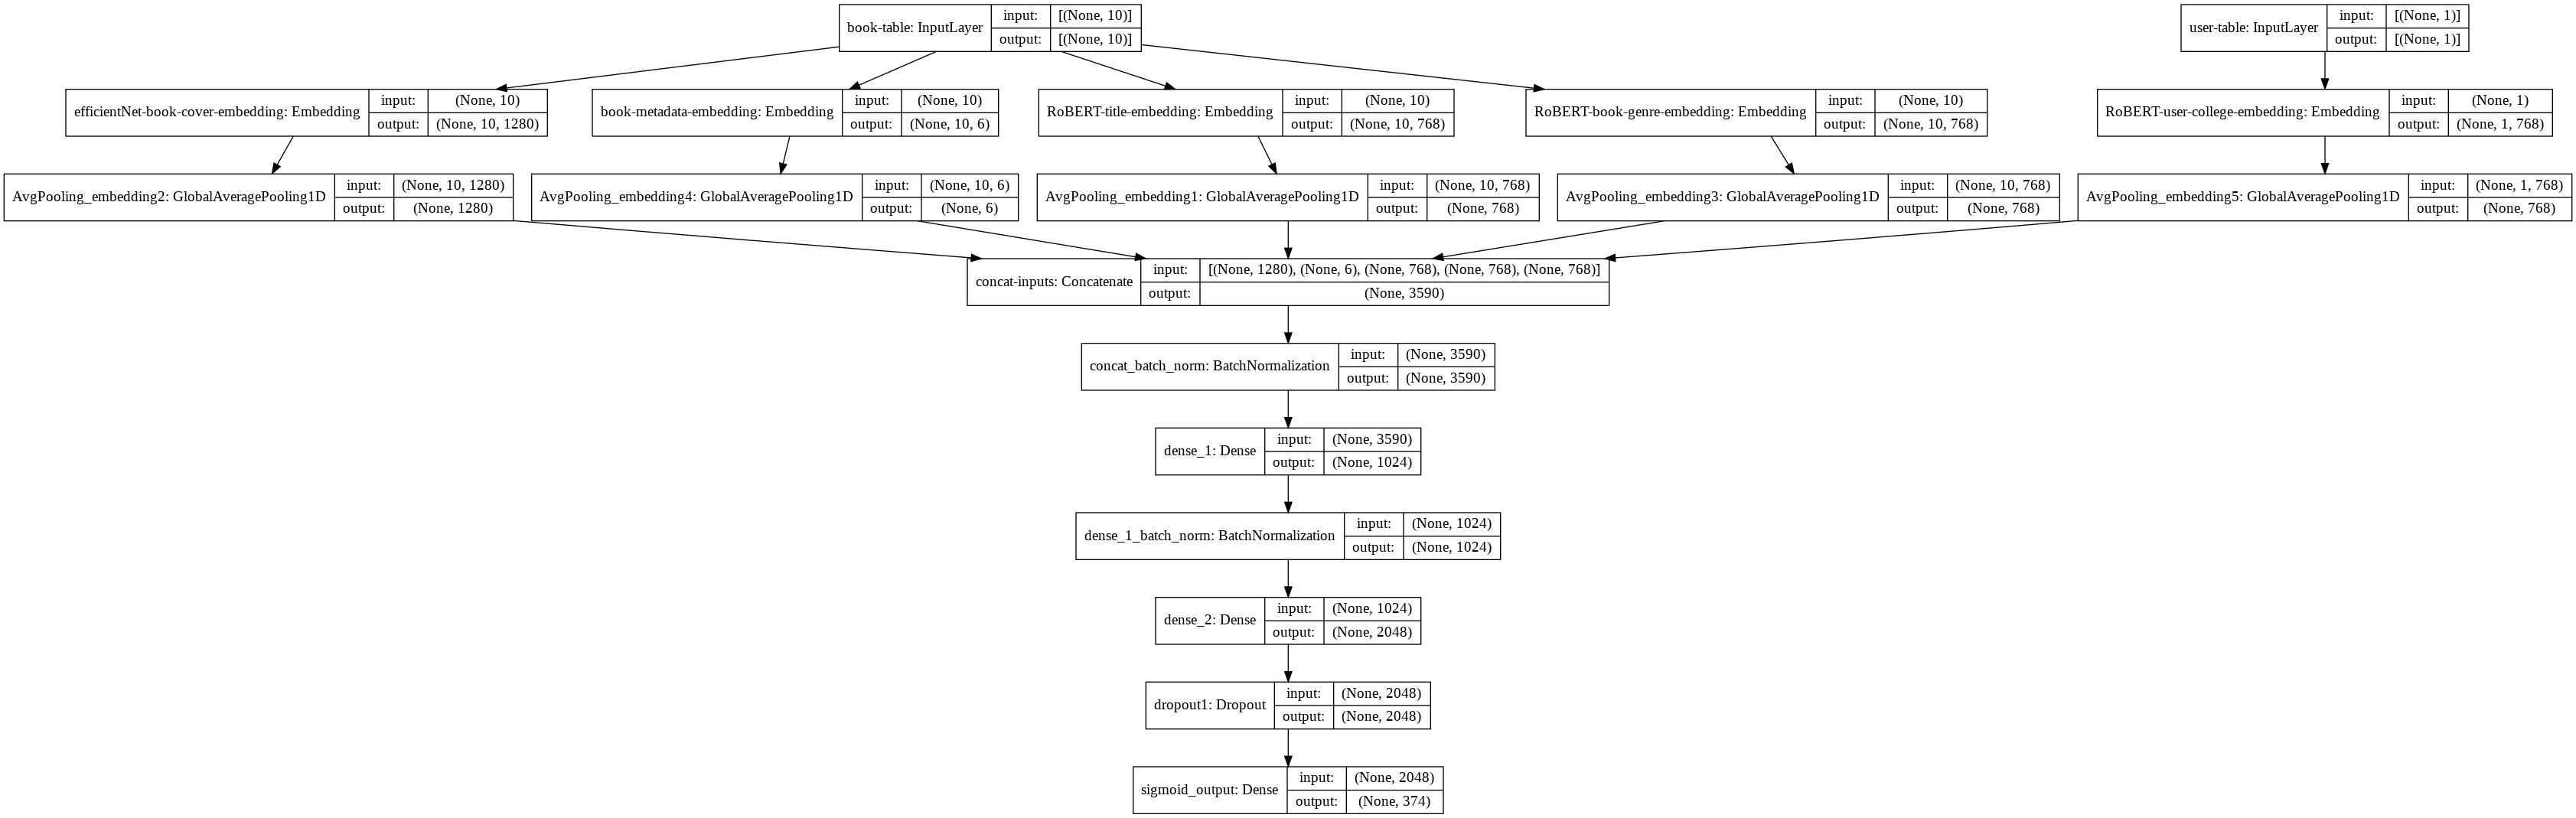

In [ ]:
model.summary()

In [ ]:
history = model.fit([X_sequence_train, X_college_train], y_sequence_train, epochs = 200, batch_size = 64)